In [1]:
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [2]:
sys.path.insert(0, '/home/reflex/refleX/lib/fastai')
from fastai.conv_learner import *

In [3]:
sys.path.insert(0, '/home/reflex/refleX/src')
from custom_metrics import f2, average_precision, average_recall, hamming_score, log_results

In [4]:
def get_data (model, PATHS, img_size, custom_transformations, batch_size, val_idxs):
    tfms = tfms_from_model(model, img_size, aug_tfms=custom_transformations, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATHS['DATA_PATH'], PATHS['DATA_FOLDER'], PATHS['CSV_PATH'], tfms=tfms,
                    suffix='.png', val_idxs=val_idxs, bs=batch_size, num_workers=2)

In [8]:
PATHS_2K = {
    'CSV_PATH': '/home/reflex/refleX/metadata/csv/fastai_train_test_split20_reflex.csv',
    'DATA_PATH': '/home/reflex/refleX/metadata/labeled/',
    'DATA_FOLDER': 'original512',
    'EXP_PATH': '/home/reflex/refleX/results/fastai_experiments'
}

In [5]:
PATHS = {
    'CSV_PATH': '/home/reflex/refleX/metadata/csv/merged_reflex.csv',
    'DATA_PATH': '/home/reflex/refleX/metadata/archives/',
    'DATA_FOLDER': 'reflex_img_512_inter_nearest',
    'EXP_PATH': '/home/reflex/refleX/results/fastai_experiments'
}

In [5]:
PATHS_POLAR = {
    'CSV_PATH': '/home/reflex/refleX/metadata/csv/augmented_sample_reflex.csv',
    'DATA_PATH': '/home/reflex/refleX/metadata/labeled/',
    'DATA_FOLDER': 'augmented_polar512',
    'EXP_PATH': '/home/reflex/refleX/results/fastai_experiments'
}

In [22]:
val_idxs = list(range(0, 1000)) # 2228 -> ERROR -> ? #(1782, 2227)

In [23]:
# Definiujemy obiekt learner'a
model = resnet34
model_weights = '/home/reflex/refleX/results/fastai_experiments/13_11_polar_sample/models/best_resnet34_imgsize512_batch32_unfreeze'
data = get_data(model, PATHS_POLAR, 512, None, 8, val_idxs)
# for cross validation see https://forums.fast.ai/t/cross-validation-with-fast-ai/7988
learn = ConvLearner.pretrained(model, data, ps=0.5, metrics=[f2, average_precision, average_recall, hamming_score])
learn.load(model_weights)

In [24]:
result = learn.predict()

In [17]:
print(result[0])

[0.0491  0.0244  0.00471 0.00004 0.01417 0.00419 0.99964]


In [12]:
print(len(result))
print(learn)

6226
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchN

- `classes` classes names
- `val_y` class labels for validation data
- `trn_y` class labels fo training data
- `val_ds` validation dataset
- `trn_ds` training dataset
- `test_ds` test dataset

In [27]:
id = 16

In [28]:
# cls, gt, pred
values = list(zip(data.classes, data.val_y[id], result[id]))
for cls, gt, prediction in values:
    print("%s %s %s" % (cls.ljust(22), str(gt).ljust(6), round(prediction, 4)))

artifact               0.0    0.0714
background_ring        1.0    0.5429
diffuse_scattering     0.0    0.006
ice_ring               0.0    0.0214
loop_scattering        1.0    0.894
non_uniform_detector   0.0    0.3565
strong_background      1.0    0.9981


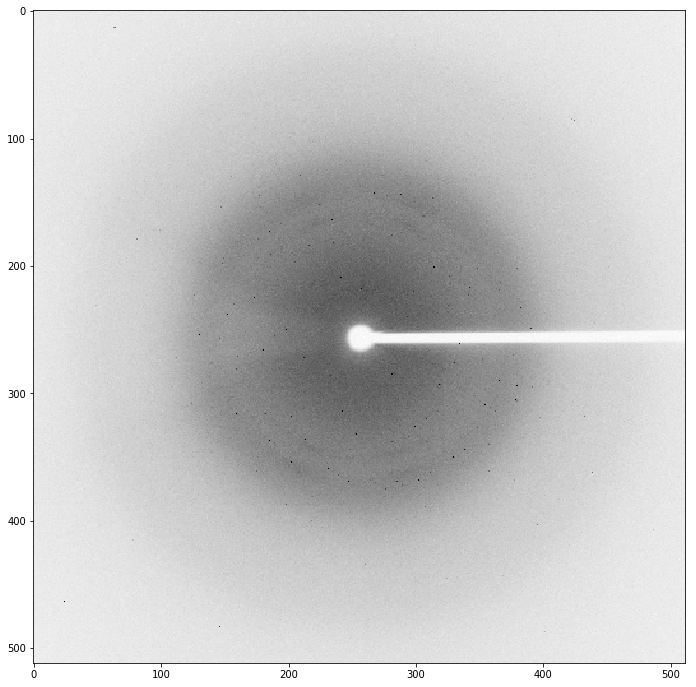

In [29]:
plt.figure(figsize = (12,12))
img_path = PATHS['DATA_PATH'] + data.val_ds.fnames[id]
img = plt.imread(img_path)
_ = plt.imshow(img, cmap='gray')

In [28]:
threshold = 0.50

In [18]:
precision = [precision_score(data.val_y[:,i], result[:,i] > threshold) for i in range(len(data.classes))]
for cls, score in list(zip(data.classes, precision)):
    print("%s %s" % (cls.ljust(24), round(score, 2)))

artifact                 0.66
background_ring          0.88
diffuse_scattering       0.78
ice_ring                 0.97
loop_scattering          0.9
non_uniform_detector     0.41
strong_background        0.93


In [19]:
recall = [recall_score(data.val_y[:,i], result[:,i] > threshold) for i in range(len(data.classes))]
for cls, score in list(zip(data.classes, recall)):
    print("%s: %s" % (cls.ljust(24), round(score, 2)))

artifact                : 0.48
background_ring         : 0.9
diffuse_scattering      : 0.44
ice_ring                : 0.82
loop_scattering         : 0.88
non_uniform_detector    : 0.1
strong_background       : 0.94


In [26]:
def plot_binary_confusion_matrix(y_true, y_pred, class_name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    classes = [class_name, 'No ' + class_name]
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    cm = np.flip(cm, 0)
    cm = np.flip(cm, 1)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    error_name = [['TP', 'FP'], ['FN', 'TN']]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, error_name[i][j],
                 horizontalalignment="center",
                 verticalalignment="bottom",
                 color="white" if cm[i, j] > thresh else "black")
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


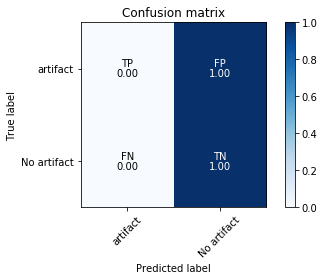


Normalized confusion matrix


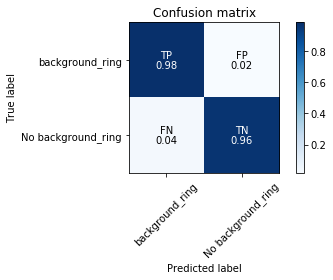


Normalized confusion matrix


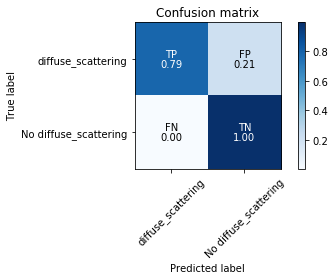


Normalized confusion matrix


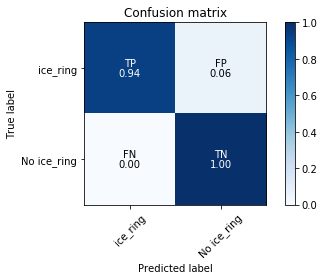


Normalized confusion matrix


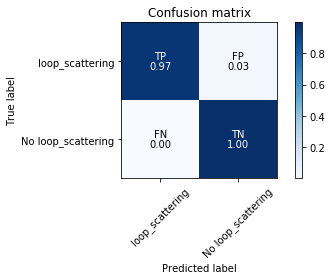


Normalized confusion matrix


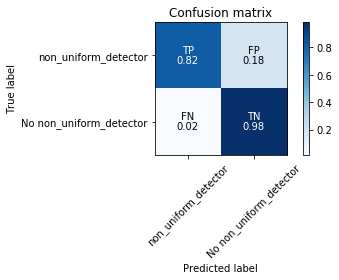


Normalized confusion matrix


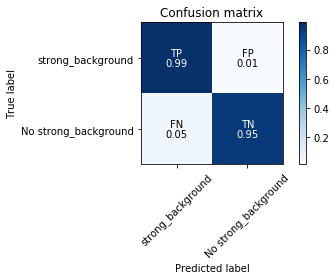

In [27]:
for i, cls in enumerate(data.classes):
    plot_binary_confusion_matrix(data.val_y[:,i], result[:,i] > threshold, class_name=cls, normalize=True)
    plt.show()
    print()

In [16]:
def show(mat, name, error_type):
    artefact_col = mat[:, data.classes.index(name)]
    results = data.val_y[:, data.classes.index(name)]
    zipped = list(zip(artefact_col, results, data.val_ds.fnames))
    if error_type == 'fp':
        return sorted(filter(lambda x: not x[1] and x[0] > 0.5, zipped), key=lambda x: x[0], reverse=True)
    elif error_type == 'fn':
        return sorted(filter(lambda x: x[1] and x[0] < 0.5, zipped), key=lambda x: x[0], reverse=True)

In [36]:
fp = show(result, 'artifact', 'fp')
fp = show(result, 'artifact', 'fp')
print(f'FP: {len(fp)}')
print(f'FN: {len(fn)}')

FP: 10
FN: 21


In [ ]:
for res, tru, imname in fp[:100]:
    print(imname, res, tru)
    plt.figure(figsize = (12,12))
    img_path = PATHS['DATA_PATH'] + imname
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.show()

In [17]:
ANOMALY_NAMES = ['artifact', 'background_ring', 'diffuse_scattering', 'ice_ring', 'loop_scattering', 'non_uniform_detector','strong_background']
WRONG_CLASS_PATH = '/home/reflex/refleX/results/misclassified/'
print('\n'.join(ANOMALY_NAMES))

artifact
background_ring
diffuse_scattering
ice_ring
loop_scattering
non_uniform_detector
strong_background


In [21]:
def clean_wrong_class_results(tup):
    name = tup[2]
    name = name[name.rfind('/')+1:]
    return name
    
for anomaly_name in ANOMALY_NAMES:
    print(anomaly_name)
    fp = list(map(lambda x:clean_wrong_class_results(x), show(result, anomaly_name, 'fp')))
    fn = list(map(lambda x:clean_wrong_class_results(x), show(result, anomaly_name, 'fn')))
    with open(f'{WRONG_CLASS_PATH}{anomaly_name}_fp.txt', 'w+') as f:
        print(f'    FP: {len(fp)}')
        f.write('\n'.join(fp))
    with open(f'{WRONG_CLASS_PATH}{anomaly_name}_fn.txt', 'w+') as f:
        print(f'    FN: {len(fn)}')
        f.write('\n'.join(fn))

artifact
    FP: 297
    FN: 159
background_ring
    FP: 543
    FN: 531
diffuse_scattering
    FP: 292
    FN: 126
ice_ring
    FP: 119
    FN: 128
loop_scattering
    FP: 289
    FN: 170
non_uniform_detector
    FP: 138
    FN: 340
strong_background
    FP: 477
    FN: 166
